<a href="https://colab.research.google.com/github/omerfalach/Death-Classification-FAERS/blob/main/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##connect to google drive 
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
###Installations for google colab
!pip install category_encoders
!pip install squarify
!pip install --upgrade xgboost

     |████████████████████████████████| 82 kB 388 kB/s 
     |████████████████████████████████| 173.6 MB 7.8 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [3]:
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
import pandas as pd
import pytz
import pickle
# import pycountry_convert as pc
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import os
import warnings
import random
from sklearn.preprocessing import StandardScaler
import requests
from category_encoders import TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, roc_auc_score, recall_score, accuracy_score, make_scorer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, auc,precision_recall_curve,ConfusionMatrixDisplay,RocCurveDisplay
import sys
import plotly.express as px
from sklearn.model_selection import StratifiedKFold
from scipy import stats
from datetime import datetime as dt
import dill as dillpickle
import matplotlib.image as mpimg
from xgboost import XGBClassifier
py_file_location = "/content/drive/MyDrive/Colab Notebooks/Project/scripts"
sys.path.append(os.path.abspath(py_file_location))
import project_plots as op



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
train_features= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/preprocessed_files/train_features.csv')
test_features= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/preprocessed_files/test_features.csv')
train_labels= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/preprocessed_files/train_labels.csv')
test_labels= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/preprocessed_files/test_labels.csv')

In [5]:
#Read_csv read pandas column with lists as str
def convert_str_to_list(x):
    try:
        z= x.strip('[]').replace("'", "").split(',')
        z1 = [f.strip() for f in z]
        return  z1
    except:
        return x # replace with any suitable placeholder value
train_features['indi_pt']= train_features['indi_pt'].apply(lambda x: convert_str_to_list(x) if type(x)!=float else x)
train_features['drugname_listed']= train_features['drugname_listed'].apply(lambda x: convert_str_to_list(x) if type(x)!=float else x)
train_features['role_cod_listed']= train_features['role_cod_listed'].apply(lambda x: convert_str_to_list(x) if type(x)!=float else x)
test_features['indi_pt']= test_features['indi_pt'].apply(lambda x: convert_str_to_list(x) if type(x)!=float else x)
test_features['drugname_listed']= test_features['drugname_listed'].apply(lambda x: convert_str_to_list(x) if type(x)!=float else x)
test_features['role_cod_listed']= test_features['role_cod_listed'].apply(lambda x: convert_str_to_list(x) if type(x)!=float else x)

In [6]:
##Defining functions for custom_preprocessors
##agecolumn - fill missing_values
##Transform column_transformer matrix for XGboost
class CSCTransformer(TransformerMixin):
    def transform(self, X, y=None, **fit_params):
        return X.tocsc()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self
class ageImputer(BaseEstimator, TransformerMixin) :
    def __init__(self, column = 'age'):
        self.death_chances = None
        self.live_chances = None
        self.column = column
        self.X1 = None
        self.y = None
    def get_age_new(self,d_chances,l_chances,column,out = -100):
        try:
            out = int(out)
            if out == 1:
                ages_unichoi = [random.uniform(i.left,i.right) for i in list(d_chances['age_groups'])]
                death_ages = random.choices(ages_unichoi, weights = list(d_chances[column]), k = 1)
                return round(death_ages[0], 1)
            elif out==0:
                ages_unichoi = [random.uniform(i.left,i.right) for i in list(l_chances['age_groups'])]
                live_ages = random.choices(ages_unichoi, weights = list(l_chances[column]), k = 1)
                return round(live_ages[0], 1)
            else:
                trans = random.choices(random.uniform(i.left,i.right), weights = list(d_chances[column]), k = 1)
                return  round(trans[0], 1)
        except:
            return -1

    def fit(self, X, y=None):
        self.y = y
        self.X1 = X.merge(self.y, right_index=True, left_index=True)
        X_fixed_age_not_null = self.X1[self.X1[self.column].notnull()]
        death = X_fixed_age_not_null[X_fixed_age_not_null['outc_cod']==1]
        live = X_fixed_age_not_null[X_fixed_age_not_null['outc_cod']==0]
        self.death_chances = death[self.column].value_counts(bins= 2 ,normalize = True).to_frame()
        self.death_chances = self.death_chances.reset_index().rename(columns = {'index':'age_groups'})
        self.live_chances = live[self.column].value_counts(bins= 2 ,normalize = True).to_frame()
        self.live_chances =self.live_chances.reset_index().rename(columns = {'index':'age_groups'})
        self.X1[self.column] = self.X1.apply(lambda row: self.get_age_new(self.death_chances,self.live_chances,self.column,row['outc_cod']) if np.isnan(row[self.column]) else row[self.column],axis=1)
        X.iloc[:, 0] = self.X1[self.column]
        return  self                      
    def transform(self, X, y=None):
        X1 = X.copy()
        X1.iloc[:, 0] = X1.iloc[:, 0].apply(lambda row: self.get_age_new(self.death_chances,self.live_chances,self.column) if np.isnan(row) else row)
        return X1
###convert_sex_values_to_integer_and_fillna_randomaly
def sex_change(x):
    if x =='M':
        return 0
    elif x == 'F':
        return 1
    else:
        return random.choice([0,1])
def sex_transform_to_pipe(data):
    z = data.apply(lambda x: [sex_change(t) for t in x])
    return z
def convert_df_column_to_list(data):
    d = list(data.iloc[:, 0])
    return d

In [7]:
drug_feature = ['drugname_listed']
age_feature = ['age']
sex_feature = ['sex']
cat_features = ['occr_country']
indi_feature = ['indi_pt']
catall_features = ['drugname','occr_country']
all_features = ['age','sex','drugname','occr_country']
sex_transformer = Pipeline(steps=[('se',FunctionTransformer(sex_transform_to_pipe)),('onehot', OneHotEncoder())])
target_encoding_transformer = Pipeline(steps = [('target',TargetEncoder())])
tfidf_transformer=  Pipeline(steps=[
    ('extract_list',FunctionTransformer(convert_df_column_to_list,validate=False)),
    ('tf',TfidfVectorizer(analyzer = 'word',tokenizer=lambda x: x,
                        preprocessor=lambda x: x,lowercase = False))])
ageImputer_transformer = Pipeline(steps = 
    [("age", ageImputer()),
        ('scale', StandardScaler())])
drug_tf_idf_preprocessor =ColumnTransformer(transformers = [
    ('sex',sex_transformer,sex_feature),
    ('age2',ageImputer_transformer,age_feature),
    ('drug',tfidf_transformer,drug_feature),
    ('categorical',target_encoding_transformer,cat_features)
])
indi_tf_idf_preprocessor =ColumnTransformer(transformers = [
    ('sex',sex_transformer,sex_feature),
    ('age2',ageImputer_transformer,age_feature),
    ('indi',tfidf_transformer,indi_feature),
    ('categorical',target_encoding_transformer,cat_features)
])
baseline_preprocessor = ColumnTransformer(transformers = [
    ('sex',sex_transformer,sex_feature),
    ('age',ageImputer_transformer,age_feature),
    ('categorical',target_encoding_transformer,catall_features)])

In [8]:
class set_modeling():
    def __init__(self, num_val_folds = 5):
        #Initialze the general parameters
        self.score_to_optimize = 'AUC'
        self.verbose = 10
        self.n_experiments = int(1e1)
        self.n_jobs=-2 
        self.num_val_folds = num_val_folds
        self.splitter = StratifiedKFold(self.num_val_folds)
        #Initiaze scorers
        self.auc_scorer = None
        self.precision_scorer = None
        self.recall_scorer = None
        self.precision_recall_scorer = None
        self.scorers = dict
        self.hyper_opt = None 
    ##get roc_auc_score
    def get_roc_auc(self,gt, pred):
        return roc_auc_score(gt, pred, average='weighted')
    def get_precision(self,gt, pred):
        return precision_score(gt, pred, average='weighted')
    def get_recall(self,gt, pred):
        return recall_score(gt, pred, average='weighted')
    def get_precision_recall_fscore_support(self,gt, pred):
        precision,recall,f2_score,support = precision_recall_fscore_support(gt, pred,beta = 2,average='weighted')
        return f2_score
    def set_scorers(self):
        self.auc_scorer = make_scorer(self.get_roc_auc, needs_proba=True)
        self.precision_scorer = make_scorer(self.get_precision)
        self.recall_scorer = make_scorer(self.get_recall)
        self.precision_recall_scorer = make_scorer(self.get_precision_recall_fscore_support)
        self.scorers = {'AUC':  self.auc_scorer, 
           'Precision': self.precision_scorer, 'Recall': self.recall_scorer,
           'Accuracy': 'accuracy'}
    def optimize_predict(self,train_features, train_labels,test_features,test_labels,pipeline,param):
        print(type(train_labels[0:10]))
        self.set_scorers()
        self.hyper_opt = RandomizedSearchCV(pipeline, param,n_iter = self.n_experiments,
                           scoring = self.scorers, n_jobs =  self.n_jobs, cv=self.splitter,
                           refit=self.score_to_optimize,pre_dispatch =2,
                           return_train_score=False, verbose=self.verbose)
        tr_val_sequences, tr_val_labels = train_features, train_labels
        num_label_apperances = tr_val_labels.value_counts()
        min_label_apperances = min(num_label_apperances)
        if self.num_val_folds > min_label_apperances:
            self.hyper_opt.cv = StratifiedKFold(min_label_apperances)
        start_time = dt.now()
        print(f"Fitting (training) the models and performing hyper parameter search. "
              f"Time: {start_time}")
        self.hyper_opt.fit(tr_val_sequences, tr_val_labels)
        best_ind = self.hyper_opt.best_index_
        scores = {}
        for scorer in self.scorers:
            scores[scorer] = self.hyper_opt.cv_results_['mean_test_' + scorer][best_ind]
        scores_str = '\n'.join(f"{k}: {v:.3f}" for k, v in scores.items())
        print(f'---Algorithm performance---: \n{scores_str}\n-------------')


        end_time = dt.now()
        duration = (end_time - start_time).total_seconds()
        print(f'Training took {duration} seconds')


In [9]:
class pipes_training(set_modeling):
        def __init__(self, preprocessor = None,num_val_folds = 5):
            set_modeling.__init__(self)
            self.reg_coef_logrange = (0, 3, 5)
            self.min_dfs_logrange = (0, 2, 1)
            # Initialze featuers
            self.drug_feature = ['drugname']
            self.age_feature = ['age']
            self.sex_feature = ['sex']
            self.cat_features = ['occr_country']
            self.catall_features = ['drugname','occr_country']
            self.naive_preprocessor = preprocessor
            # Initialze the estimators
            self.clf1 = LogisticRegression()
            self.clf2 = RandomForestClassifier()
            self.clf3 = XGBClassifier()
            # self.classifiers = [self.clf1,self.clf2]
            self.classifiers = [self.clf1]
            self.models = []
            # Initiaze dictionaries for hyperparameters
            self.param1 = {}
            self.param2 = {}
            self.param3 = {}
            self.params = {}
        def log_range(self,lower, upper, samples_per_decade, is_int=True):
            samples = 1 + (upper - lower) * samples_per_decade
            samples = int(round(samples))
            if is_int:
                return [int(round(i)) for i in np.logspace(lower, upper, samples)]
            else:
                return list(np.logspace(lower, upper, samples))
        def set_hyperparameters(self): #hyperparameters for each classifier
            ##fill logistic regression parameters
            self.param1['feature_extractor']= self.naive_preprocessor
            # self.param1['feature_extractor__indi__tf__min_df']= [0.01,0.05,0.1]
            self.param1['feature_extractor__categorical__target__min_samples_leaf']= [200,1000,2000]
            self.param1['classifier__solver']=['lbfgs']
            self.param1['classifier__multi_class']=['auto']
            self.param1['classifier__max_iter']=[int(1e6)]
            self.param1['classifier__class_weight']=['balanced']
            self.param1['classifier__C'] = self.log_range(*self.reg_coef_logrange, is_int=False)
#             self.param1['classifier__penalty'] = ['l1', 'l2']
            self.param1['classifier'] = [self.clf1]

             ##fill randomforest parameters
            self.param2['feature_extractor__categorical__target__min_samples_leaf']= [200,1000]
            self.param2['feature_extractor']=self.naive_preprocessor
            self.param2['classifier__n_estimators'] = [10]
            self.param2['classifier__max_depth'] = [5, 10, 20]
            self.param2['classifier__class_weight'] = ['balanced_subsample']
            self.param2['classifier'] = [self.clf2]

            ##fill knn parameters
            self.param3['feature_extractor']=[naive_preprocessor],
            self.param3['classifier'] = [self.clf3]

            if self.naive_preprocessor==drug_tf_idf_preprocessor:
                    self.param1['feature_extractor__drug__tf__min_df']= [0.001,0.005,0.01,0.05]
                    self.param2['feature_extractor__drug__tf__min_df']= [0.001,0.005,0.01,0.05]
            if self.naive_preprocessor==indi_tf_idf_preprocessor:
                    self.param1['feature_extractor__indi__tf__min_df']= [0.001,0.005,0.01,0.05]
                    self.param2['feature_extractor__indi__tf__min_df']= [0.001,0.005,0.01,0.05]

            self.params = [self.param1,self.param2,self.param3]
        def add_params(self,new_params):
          self.params.append(new_params)
        def train_pipes(self,train_features, train_labels,test_features,test_labels,default_params = True,params = 0):
                if default_params ==True:
                    self.set_hyperparameters()
                params_for_tuning = self.params[params]
                for i in self.classifiers:
                    print(i)
                    p = Pipeline(steps = [('feature_extractor','passthrough'),('classifier',i)])
#                     print(p)
                    self.optimize_predict(train_features, train_labels,test_features,test_labels,p, params_for_tuning)
                    self.models.append(self.hyper_opt)
                return self.models

# ***Baseline Model***


In [10]:
##Training - Baseline model_5Folds
##Logistic_Regression
# baseline = pipes_training(preprocessor = [baseline_preprocessor])
# models = baseline.train_pipes(train_features,train_labels['outc_cod'],test_features,test_labels['outc_cod'])
filename = '/content/drive/MyDrive/Colab Notebooks/Project/models/baseline_traget_encoding_Logistic_Regression.pkl'
# pickle.dump(models[0], open(filename, 'wb'))
###Results
baseline_logreg = dillpickle.load(open(filename, 'rb'))
op.get_train_scores(baseline_logreg)

---Algorithm performance---: 
AUC: 0.725
Precision: 0.812
Recall: 0.755
Accuracy: 0.755
-------------


In [11]:
##Training - Baseline model_5Folds
##Random_Forest

##Training and save pickle file
# baseline = pipes_training(preprocessor = [baseline_preprocessor])
# models = baseline.train_pipes(train_features,train_labels['outc_cod'],test_features,test_labels['outc_cod'],params=1)
filename = '/content/drive/MyDrive/Colab Notebooks/Project/models/baseline_traget_encoding_Random_Forest.pkl'
# pickle.dump(models[0], open(filename, 'wb'))

###Loading Results
baseline_rforest = dillpickle.load(open(filename, 'rb'))
op.get_train_scores(baseline_rforest)

---Algorithm performance---: 
AUC: 0.743
Precision: 0.821
Recall: 0.703
Accuracy: 0.703
-------------


In [12]:
##Training - Baseline model_5Folds
##XGboost

#Set Parameters
# new_params_baseline = {}
# new_params_baseline['feature_extractor']=[baseline_preprocessor]
# new_params_baseline['classifier__num_parallel_tree'] =  [4]
# new_params_baseline['feature_extractor__categorical__target__min_samples_leaf']= [300]
# new_params_baseline['classifier__objective'] =  ['binary:logistic']
# new_params_baseline['classifier__tree_method'] =  ['gpu_hist']
# new_params_baseline['classifier__eval_metric'] = ['auc']
# new_params_baseline['classifier__min_child_weight'] =  [2,5]
# new_params_baseline['classifier__gamma'] = [1]
# new_params_baseline['classifier__scale_pos_weight']=[0.85/0.15]
# new_params_baseline['classifier__subsample']=[0.5]
# new_params_baseline['classifier__colsample_bytree']=[0.6]
# new_params_baseline['classifier__max_delta_step']=[10]
# new_params_baseline['classifier__max_depth']= [20]
# new_params_baseline['classifier__learning_rate']= [0.001,0.01]

##Training and save pickle file
# baseline = pipes_training(preprocessor = [baseline_preprocessor])
# models = baseline.train_pipes(train_features,train_labels['outc_cod'],test_features,test_labels['outc_cod'],params=0)
filename = '/content/drive/MyDrive/Colab Notebooks/Project/models/baseline_traget_encoding_XGboost.pkl'
# pickle.dump(models[0], open(filename, 'wb'))

###Loading Results
baseline_xgboost = dillpickle.load(open(filename, 'rb'))
op.get_train_scores(baseline_xgboost)

[06:07:44] WARNING: ../src/gbm/gbtree.cc:386: Loading from a raw memory buffer on CPU only machine.  Changing tree_method to hist.
[06:07:44] WARNING: ../src/learner.cc:223: No visible GPU is found, setting `gpu_id` to -1
---Algorithm performance---: 
AUC: 0.751
Precision: 0.824
Recall: 0.703
Accuracy: 0.703
-------------


# **Drug TF-IDF Model** 

In [13]:
##Training - Using_tf-idf_vectorizer_for_drugname_feature_5Folds
##Logistic_Regression
# baseline = pipes_training(preprocessor =[drug_tf_idf_preprocessor])
# models = baseline.train_pipes(train_features,train_labels['outc_cod'],test_features,test_labels['outc_cod'])
filename = '/content/drive/MyDrive/Colab Notebooks/Project/models/drug_tf_idf_Logistic_Regression.pkl'
# pickle.dump(models[0], open(filename, 'wb'))
###Results
drug_tfidf_logreg = dillpickle.load(open(filename, 'rb'))
op.get_train_scores(drug_tfidf_logreg)

---Algorithm performance---: 
AUC: 0.618
Precision: 0.780
Recall: 0.708
Accuracy: 0.708
-------------


In [14]:
##Training - Using_tf-idf_vectorizer_for_drugname_feature_5Folds
##Random_Forest
# baseline = pipes_training(preprocessor =[drug_tf_idf_preprocessor])
# models = baseline.train_pipes(train_features,train_labels['outc_cod'],test_features,test_labels['outc_cod'],params=1)
filename = '/content/drive/MyDrive/Colab Notebooks/Project/models/drug_tf_idf_Random_Forest.pkl'
# pickle.dump(models[0], open(filename, 'wb'))
###Results
drug_tfidf_rforest = dillpickle.load(open(filename, 'rb'))
op.get_train_scores(drug_tfidf_rforest)

---Algorithm performance---: 
AUC: 0.733
Precision: 0.815
Recall: 0.779
Accuracy: 0.779
-------------


(-0.5, 237.5, 105.5, -0.5)

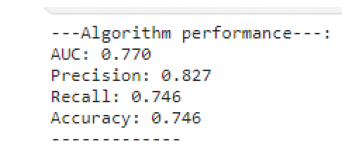

In [15]:
##Training - Using_tf-idf_vectorizer_for_drugname_feature_5Folds
##XGboost
##Set Parmeters
# new_params_drug_tf_idf = {}
# new_params_drug_tf_idf['feature_extractor']=[drug_tf_idf_preprocessor]
# new_params_drug_tf_idf['sparse'] = [CSCTransformer()]
# new_params_drug_tf_idf['classifier__num_parallel_tree'] =  [4]
# new_params_drug_tf_idf['feature_extractor__categorical__target__min_samples_leaf']= [500]
# new_params_drug_tf_idf['feature_extractor__drug__tf__min_df']= [0.0001,0.0005,0.001,0.05]
# new_params_drug_tf_idf['classifier__objective'] =  ['binary:logistic']
# new_params_drug_tf_idf['classifier__tree_method'] =  ['gpu_hist']
# new_params_drug_tf_idf['classifier__eval_metric'] = ['auc']
# new_params_drug_tf_idf['classifier__min_child_weight'] =  [5]
# new_params_drug_tf_idf['classifier__gamma'] = [1]
# new_params_drug_tf_idf['classifier__scale_pos_weight']=[0.85/0.15]
# new_params_drug_tf_idf['classifier__subsample']=[0.5]
# new_params_drug_tf_idf['classifier__colsample_bytree']=[0.6]
# new_params_drug_tf_idf['classifier__max_delta_step']=[1]
# new_params_drug_tf_idf['classifier__max_depth']= [10,20]
# new_params_drug_tf_idf['classifier__learning_rate']= [0.001,0.1,0.2,0.4]

##Training and save pickle file
# filename = '/content/drive/MyDrive/Colab Notebooks/drug_tf_idf_XGboost.pkl'
# drug_train =pipes_training()
# drug_train.add_params(new_params_drug_tf_idf)
# models = drug_train.train_pipes(train_features, train_labels['outc_cod'],test_features,test_labels['outc_cod'],default_params = False,params = 0)
# pickle.dump(models[0], open(filename, 'wb'))



###Loading Results
filename_csv = '/content/drive/MyDrive/Colab Notebooks/Project/models/drug_tf_idf_XGboost.csv'
results = '/content/drive/MyDrive/Colab Notebooks/Project/models/drug_tf_idf_XGboost_results.PNG'
##Pickle created with other pandas version(Kaggle), cant be loaded as pickle file
# drug_tf_idf_XGBoost = dillpickle.load(open(filename, 'rb'))
xgboost_drug_results = pd.read_csv(filename_csv)
image = mpimg.imread(results)
plt.imshow(image)
plt.axis('off')

# **Indication TF-IDF Model**

In [16]:
##Training - Using_tf-idf_vectorizer_for_indi_pt_feature_5Folds
##Logistic_Regression
# baseline = pipes_training(preprocessor =[indi_tf_idf_preprocessor])
# models = baseline.train_pipes(train_features,train_labels['outc_cod'],test_features,test_labels['outc_cod'])
filename = '/content/drive/MyDrive/Colab Notebooks/Project/models/indi_tf_idf_Logistic_Regression_onehot.pkl'
# pickle.dump(models[0], open(filename, 'wb'))
###Results
indi_tfidf_logreg = dillpickle.load(open(filename, 'rb'))
op.get_train_scores(indi_tfidf_logreg)

---Algorithm performance---: 
AUC: 0.695
Precision: 0.798
Recall: 0.696
Accuracy: 0.696
-------------


In [17]:
##Training - Using_tf-idf_vectorizer_for_indi_pt_feature_5Folds
##Random_Forest
# baseline = pipes_training(preprocessor =[indi_tf_idf_preprocessor])
# models = baseline.train_pipes(train_features,train_labels['outc_cod'],test_features,test_labels['outc_cod'],params=1)
filename = '/content/drive/MyDrive/Colab Notebooks/Project/models/indi_tf_idf_Random_Forest.pkl'
# pickle.dump(models[0], open(filename, 'wb'))
###Results
indi_tfidf_rforest = dillpickle.load(open(filename, 'rb'))
op.get_train_scores(indi_tfidf_rforest)


---Algorithm performance---: 
AUC: 0.744
Precision: 0.817
Recall: 0.745
Accuracy: 0.745
-------------


(-0.5, 265.5, 91.5, -0.5)

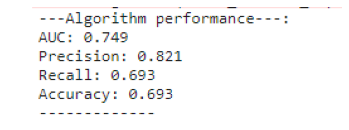

In [18]:
##Training - Using_tf-idf_vectorizer_for_indi_pt_feature_5Folds
##XGboost
##Set Parmeters
# new_params_indi_tf_idf = {}
# new_params_indi_tf_idf['feature_extractor']=[indi_tf_idf_preprocessor]
# new_params_indi_tf_idf['sparse'] = [CSCTransformer()]
# new_params_indi_tf_idf['classifier__num_parallel_tree'] =  [4]
# new_params_indi_tf_idf['feature_extractor__categorical__target__min_samples_leaf']= [500]
# new_params_indi_tf_idf['feature_extractor__indi__tf__min_df']= [0.0001,0.0005,0.001,0.05]
# new_params_indi_tf_idf['classifier__objective'] =  ['binary:logistic']
# new_params_indi_tf_idf['classifier__tree_method'] =  ['gpu_hist']
# new_params_indi_tf_idf['classifier__eval_metric'] = ['auc']
# new_params_indi_tf_idf['classifier__min_child_weight'] =  [5]
# new_params_indi_tf_idf['classifier__gamma'] = [1]
# new_params_indi_tf_idf['classifier__scale_pos_weight']=[0.85/0.15]
# new_params_indi_tf_idf['classifier__subsample']=[0.5]
# new_params_indi_tf_idf['classifier__colsample_bytree']=[0.6]
# new_params_indi_tf_idf['classifier__max_delta_step']=[1,5]
# new_params_indi_tf_idf['classifier__max_depth']= [10,20]
# new_params_indi_tf_idf['classifier__learning_rate']= [0.001,0.1,0.2,0.4]


##Training and save pickle file
# filename = '/content/drive/MyDrive/Colab Notebooks/indi_tf_idf_XGboost.pkl'
# indi_train =pipes_training()
# indi_train.add_params(new_params_indi_tf_idf)
# models = indi_train.train_pipes(train_features, train_labels['outc_cod'],test_features,test_labels['outc_cod'],default_params = False,params = 0)
# pickle.dump(models[0], open(filename, 'wb'))

# pickle.dump(models[0], open(filename, 'wb'))
###Loading Results
##Pickle created with other pandas version(Kaggle), cant be loaded as pickle
#indi_tf_idf_XGBoost = dillpickle.load(open(filename, 'rb'))
filename_csv = '/content/drive/MyDrive/Colab Notebooks/Project/models/indi_tf_idf_XGboost_results.csv'
results = '/content/drive/MyDrive/Colab Notebooks/Project/models/indi_tf_idf_XGboost_results.PNG'
xgboost_indi_results = pd.read_csv(filename_csv)
image = mpimg.imread(results)
plt.imshow(image)
plt.axis('off')

**Best Classifieres Comparsion**

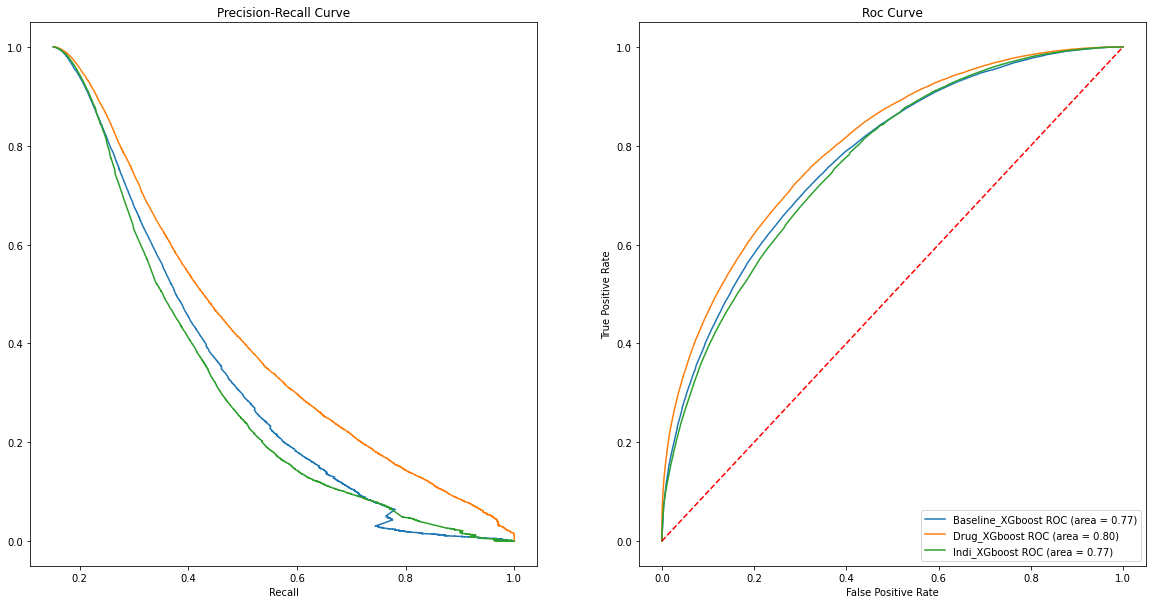

In [22]:
best_classifiers = {'Baseline_XGboost':baseline_xgboost,'Drug_XGboost':xgboost_drug_results, 'Indi_XGboost':xgboost_indi_results}
compare_models(test_features,test_labels,best_classifiers)

In [20]:
def compare_models(test_features,test_labels, classifiers):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize= (20,10))
    for i in classifiers:
      if type(classifiers[i])==pd.core.frame.DataFrame:
              y_scores = classifiers[i]['y_scores']
              fpr, tpr, thresholds =roc_curve(test_labels, y_scores)
              precision, recall, thresholds = precision_recall_curve(test_labels, y_scores)
              auc = roc_auc_score(test_labels, y_scores)
              ax1.plot(precision, recall)
              ax2.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (str(i), auc))
      else:

              y_predict1 = classifiers[i].predict(test_features)
              y_scores1 =  classifiers[i].predict_proba(test_features)[:, 1]
              fpr1, tpr1, thresholds =roc_curve(test_labels, y_scores1)
              precision1, recall1, thresholds = precision_recall_curve(test_labels, y_scores1)
              auc1 = roc_auc_score(test_labels, y_scores1)
              ax1.plot(precision1, recall1)
              ax2.plot(fpr1, tpr1, label='%s ROC (area = %0.2f)' % (str(i), auc1))
    ax1.set_title('Precision-Recall Curve')
    ax2.set_title('Roc Curve')
    ax1.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.plot([0, 1], [0, 1],'r--')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend(loc="lower right")
    plt.show()